In [2]:
import os
from tqdm import tqdm
import librosa
import numpy as np
import matplotlib.pyplot as plt

In [3]:
FRAME_SIZE = 1024
N_MELS = 128
N_MFCC = 40
N_FTT = 1024
HOP_LENGTH = 512
POWER = 2.0
SR = 16000
DURATION = 10
FRAMES = int(np.ceil(SR * 10 / HOP_LENGTH))

### Calculate metrics for each machine ID

In [4]:
def get_amplitude_envelope(signal, _):
    ae = np.array([max(signal[i:i+FRAME_SIZE]) for i in range(0, len(signal), HOP_LENGTH)])
    return ae

def get_rms(signal):
    rms = librosa.feature.rms(y=signal, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
    return rms

def get_spectral_centroid(signal, sr):
    sc = librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=N_FTT, hop_length=HOP_LENGTH).squeeze()
    return sc

def get_spectral_bandwidth(signal, sr):
    sb = librosa.feature.spectral_bandwidth(y=signal, sr=sr, n_fft=N_FTT, hop_length=HOP_LENGTH).squeeze()
    return sb

def get_spectral_envelope(signal, sr):
    S = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=N_FTT, hop_length=HOP_LENGTH, n_mels=N_MELS, power=POWER)
    se = S.mean(axis=1)
    return se

In [5]:
metrics_dict = {
    "time" : {
        "amplitude_envelope": get_amplitude_envelope,
    },
    "time_frequency" : {
        "spectral_centroid": get_spectral_centroid,
        "spectral_bandwidth": get_spectral_bandwidth,
    },
    "frequency" : {
        "spectral_envelope": get_spectral_envelope,
    }
}

In [6]:
def calculate_stats(file_list):
    metrics = {}
    for file in file_list:
        signal, sr = librosa.load(file, sr=SR)
        signal = librosa.util.fix_length(signal, size=DURATION * SR)
        for domain, metric in metrics_dict.items():
            y_axis = N_MELS if domain == "frequency" else FRAMES
            for metric_name, metric_func in metric.items():
                if metric_name not in metrics:
                    metrics[metric_name] = np.empty((0, y_axis))
                metric_value = metric_func(signal, sr)
                metrics[metric_name] = np.vstack((metrics[metric_name], metric_value))
    
    return metrics

In [7]:
data_dir = os.path.join("data", "dev")
machine_types = os.listdir(data_dir)

machine_stats = {}
for machine_type in tqdm(machine_types):
    machine_ids = {x.split("_")[2] for x in os.listdir(os.path.join(data_dir, machine_type, "train"))}
    for machine_id in machine_ids:
        file_list = [
            os.path.join(data_dir, machine_type, "train", file)
            for file in os.listdir(os.path.join(data_dir, machine_type, "train"))
            if file.split("_")[2] == machine_id
        ]
        stats = calculate_stats(file_list)
        machine_stats[machine_type + "_" + machine_id] = stats

100%|██████████| 6/6 [31:18<00:00, 313.02s/it]


### Aggregate stats by calculating mean

In [8]:
agg_stats = {}
for machine, stats in machine_stats.items():
    machine_type, machine_id = machine.split("_")
    for metric, value in stats.items():
        if metric not in agg_stats:
            agg_stats[metric] = {}
        if machine_type not in agg_stats[metric]:
            agg_stats[metric][machine_type] = {}
        agg_stats[metric][machine_type][machine_id] = value.mean(axis=0)

### Plot metrics for each machine ID

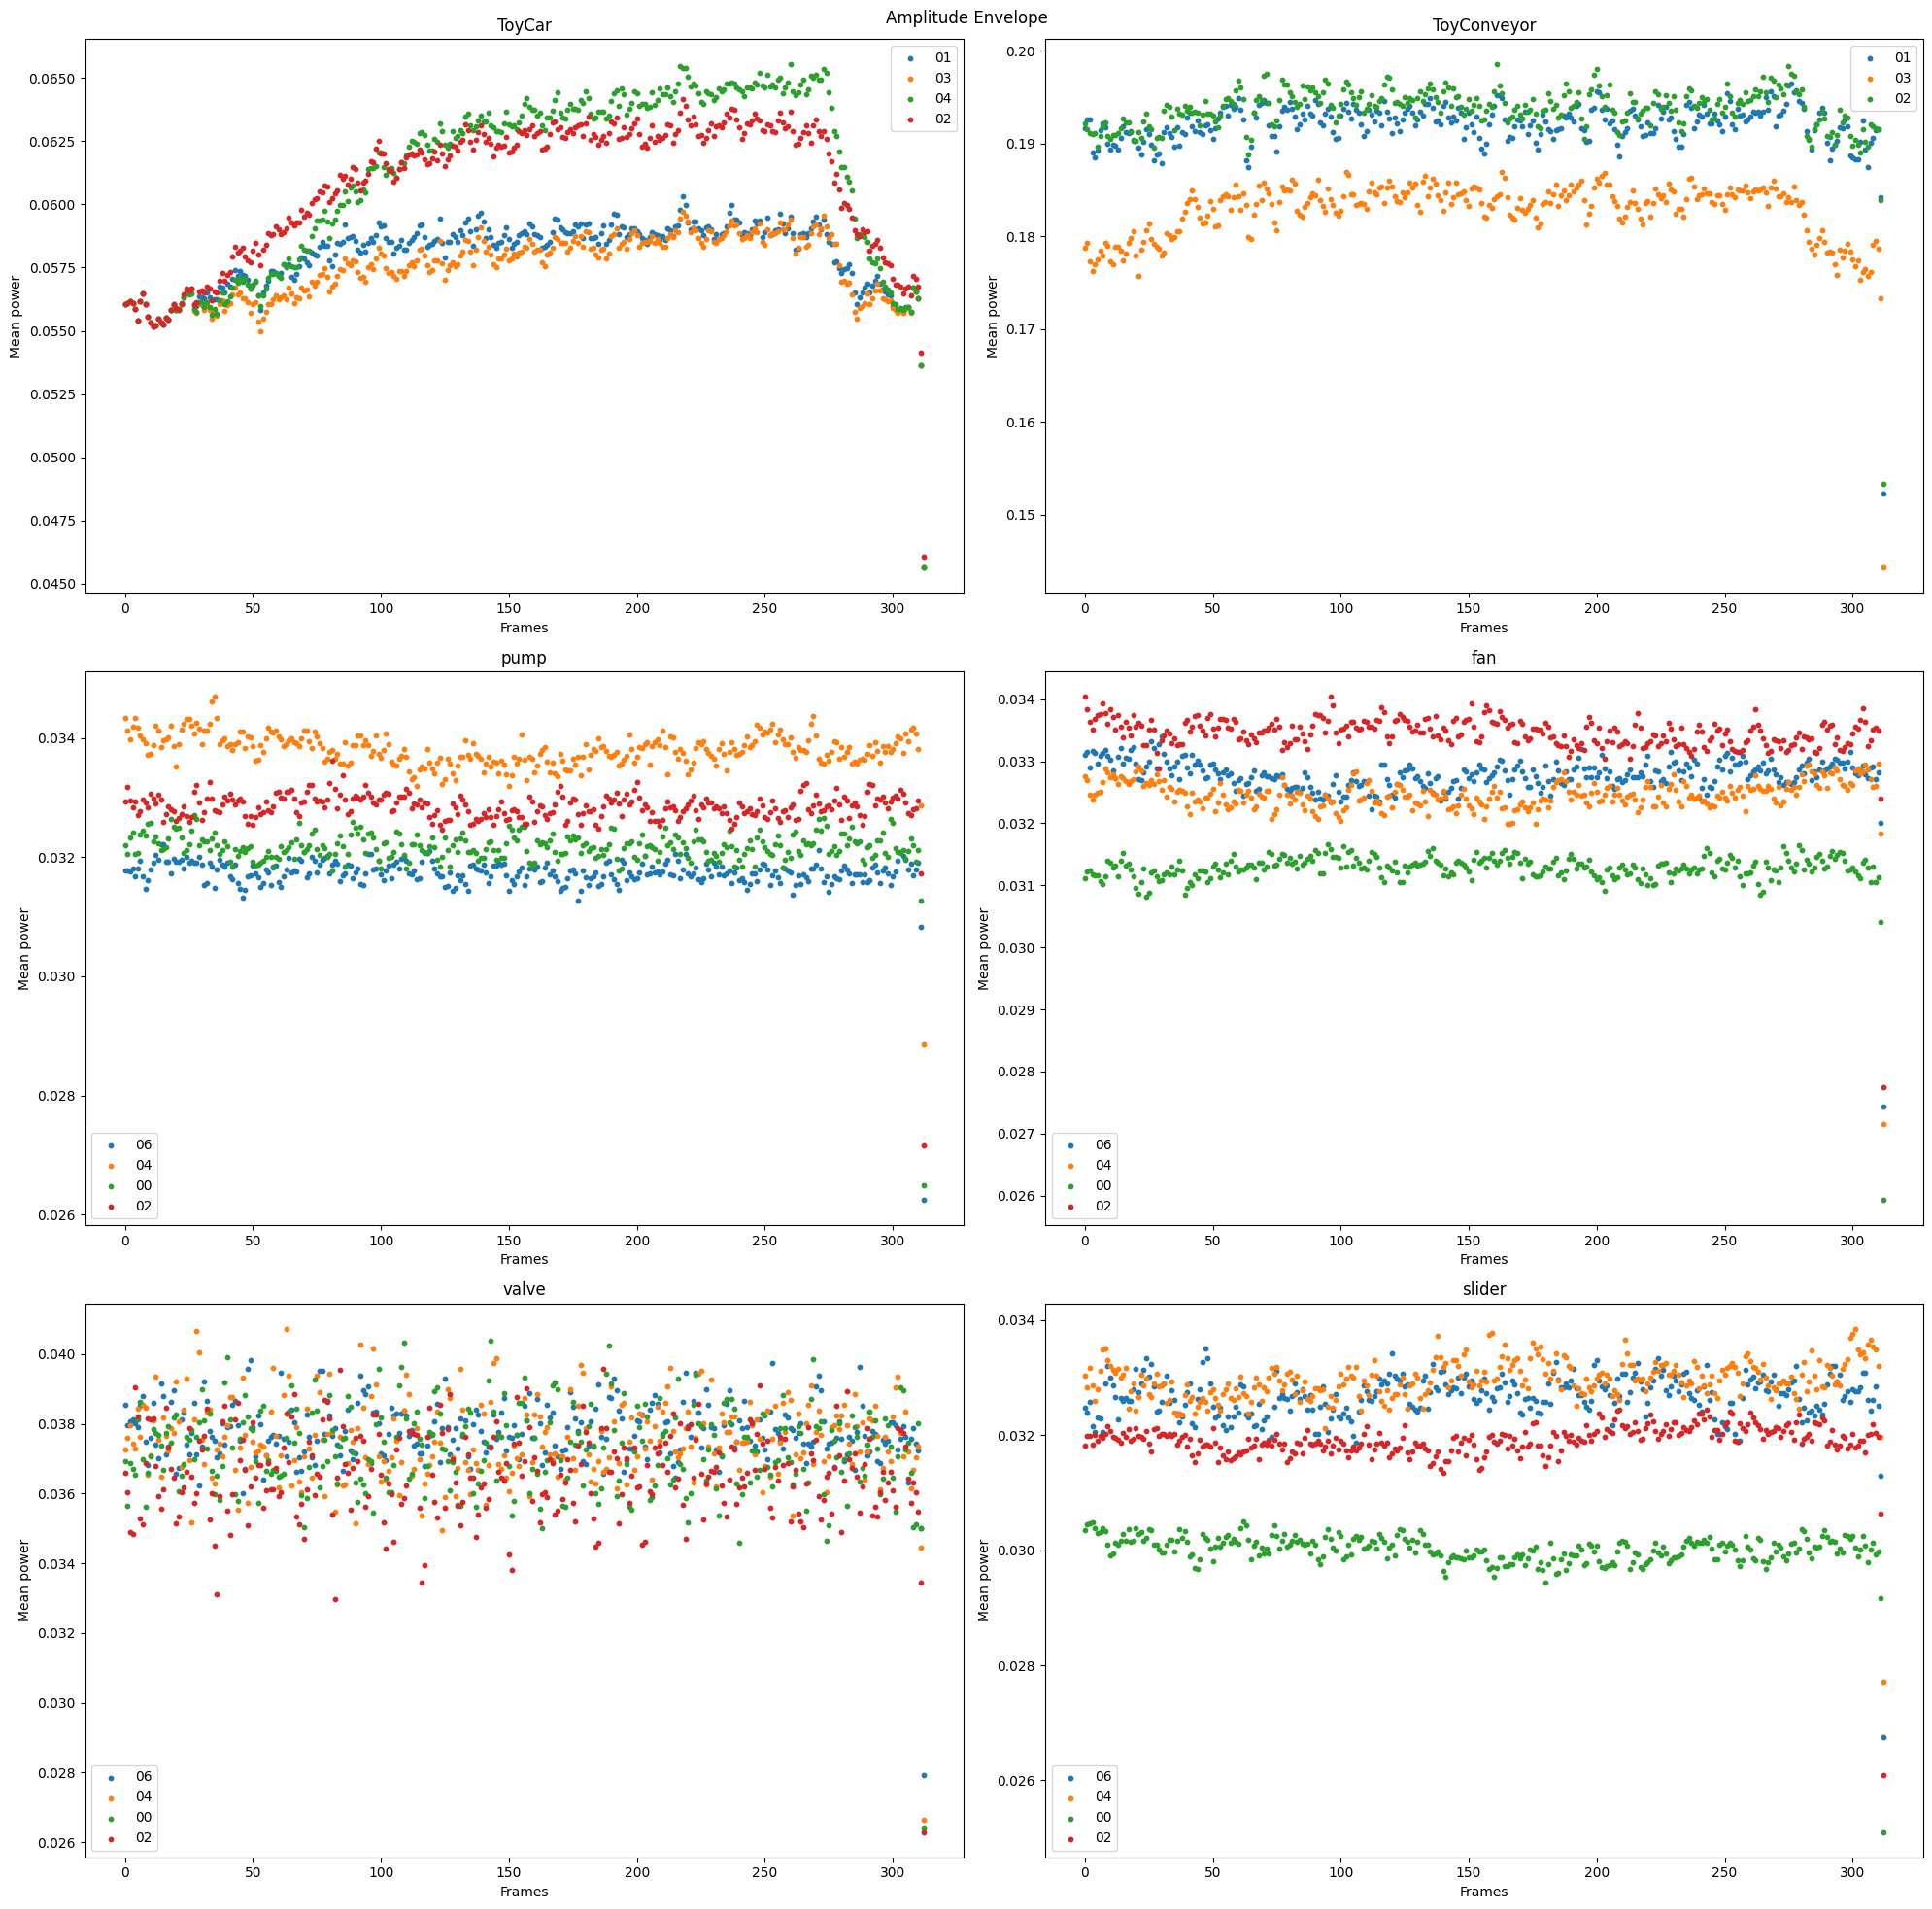

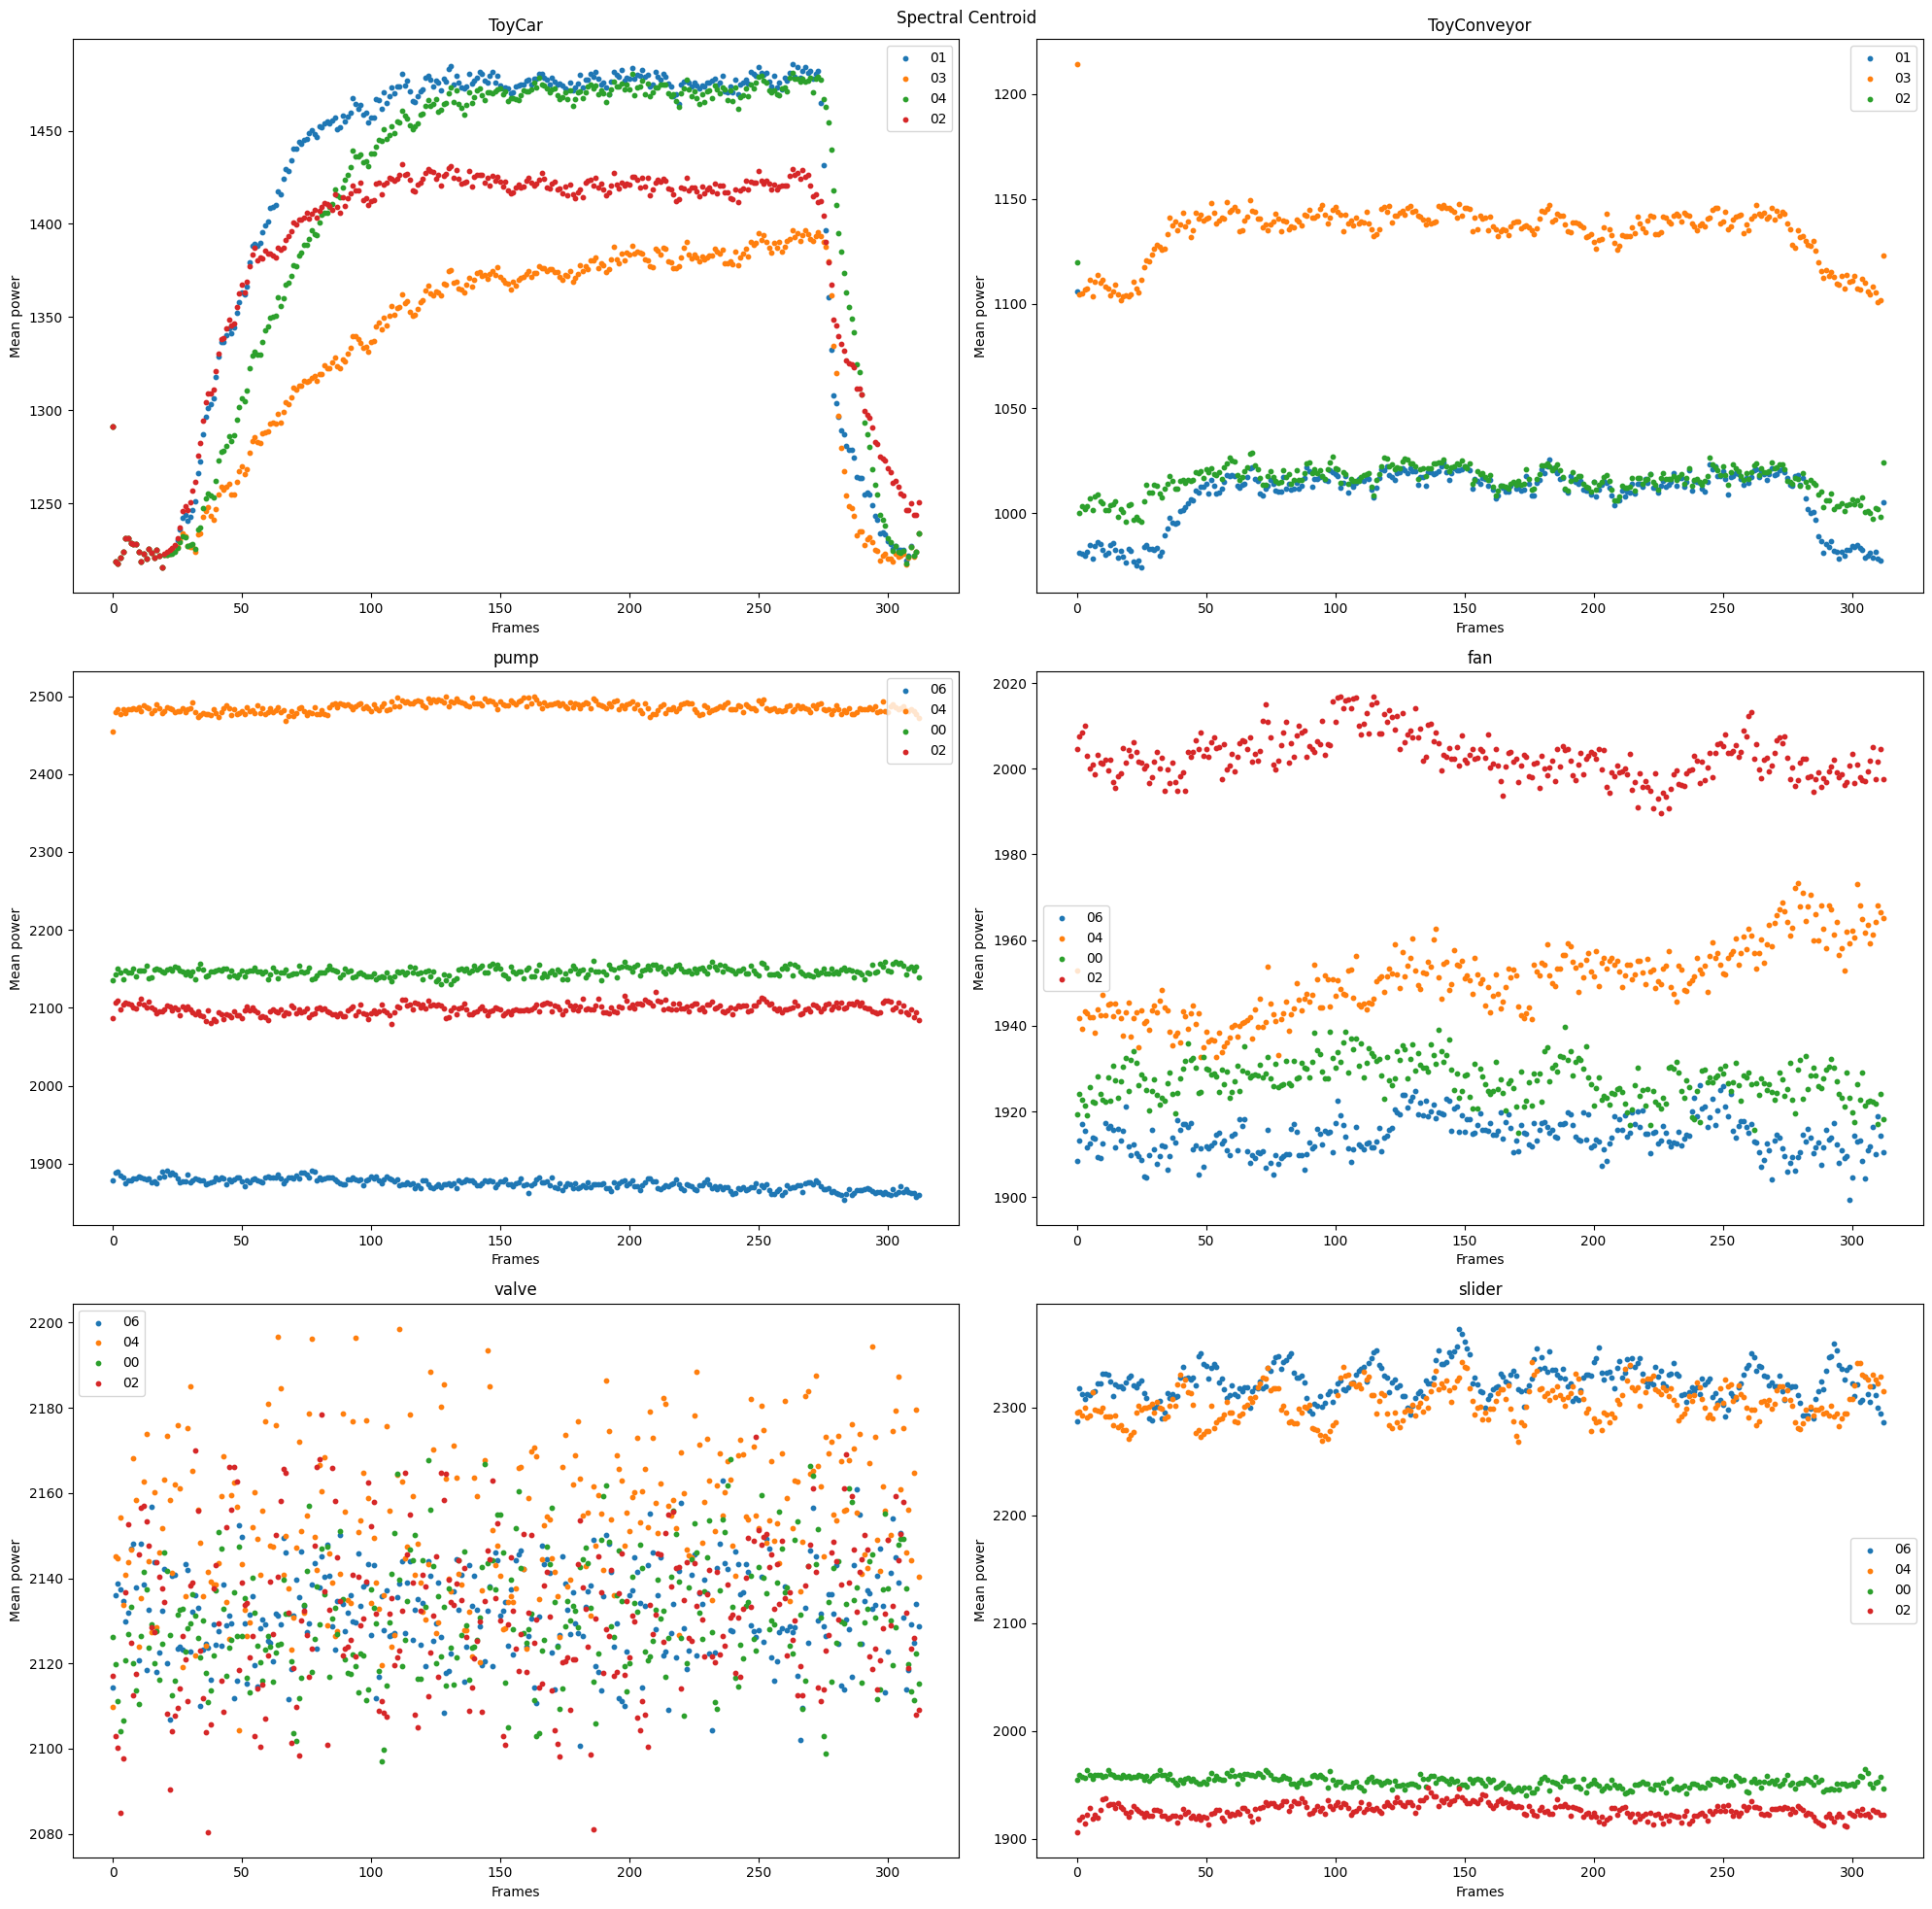

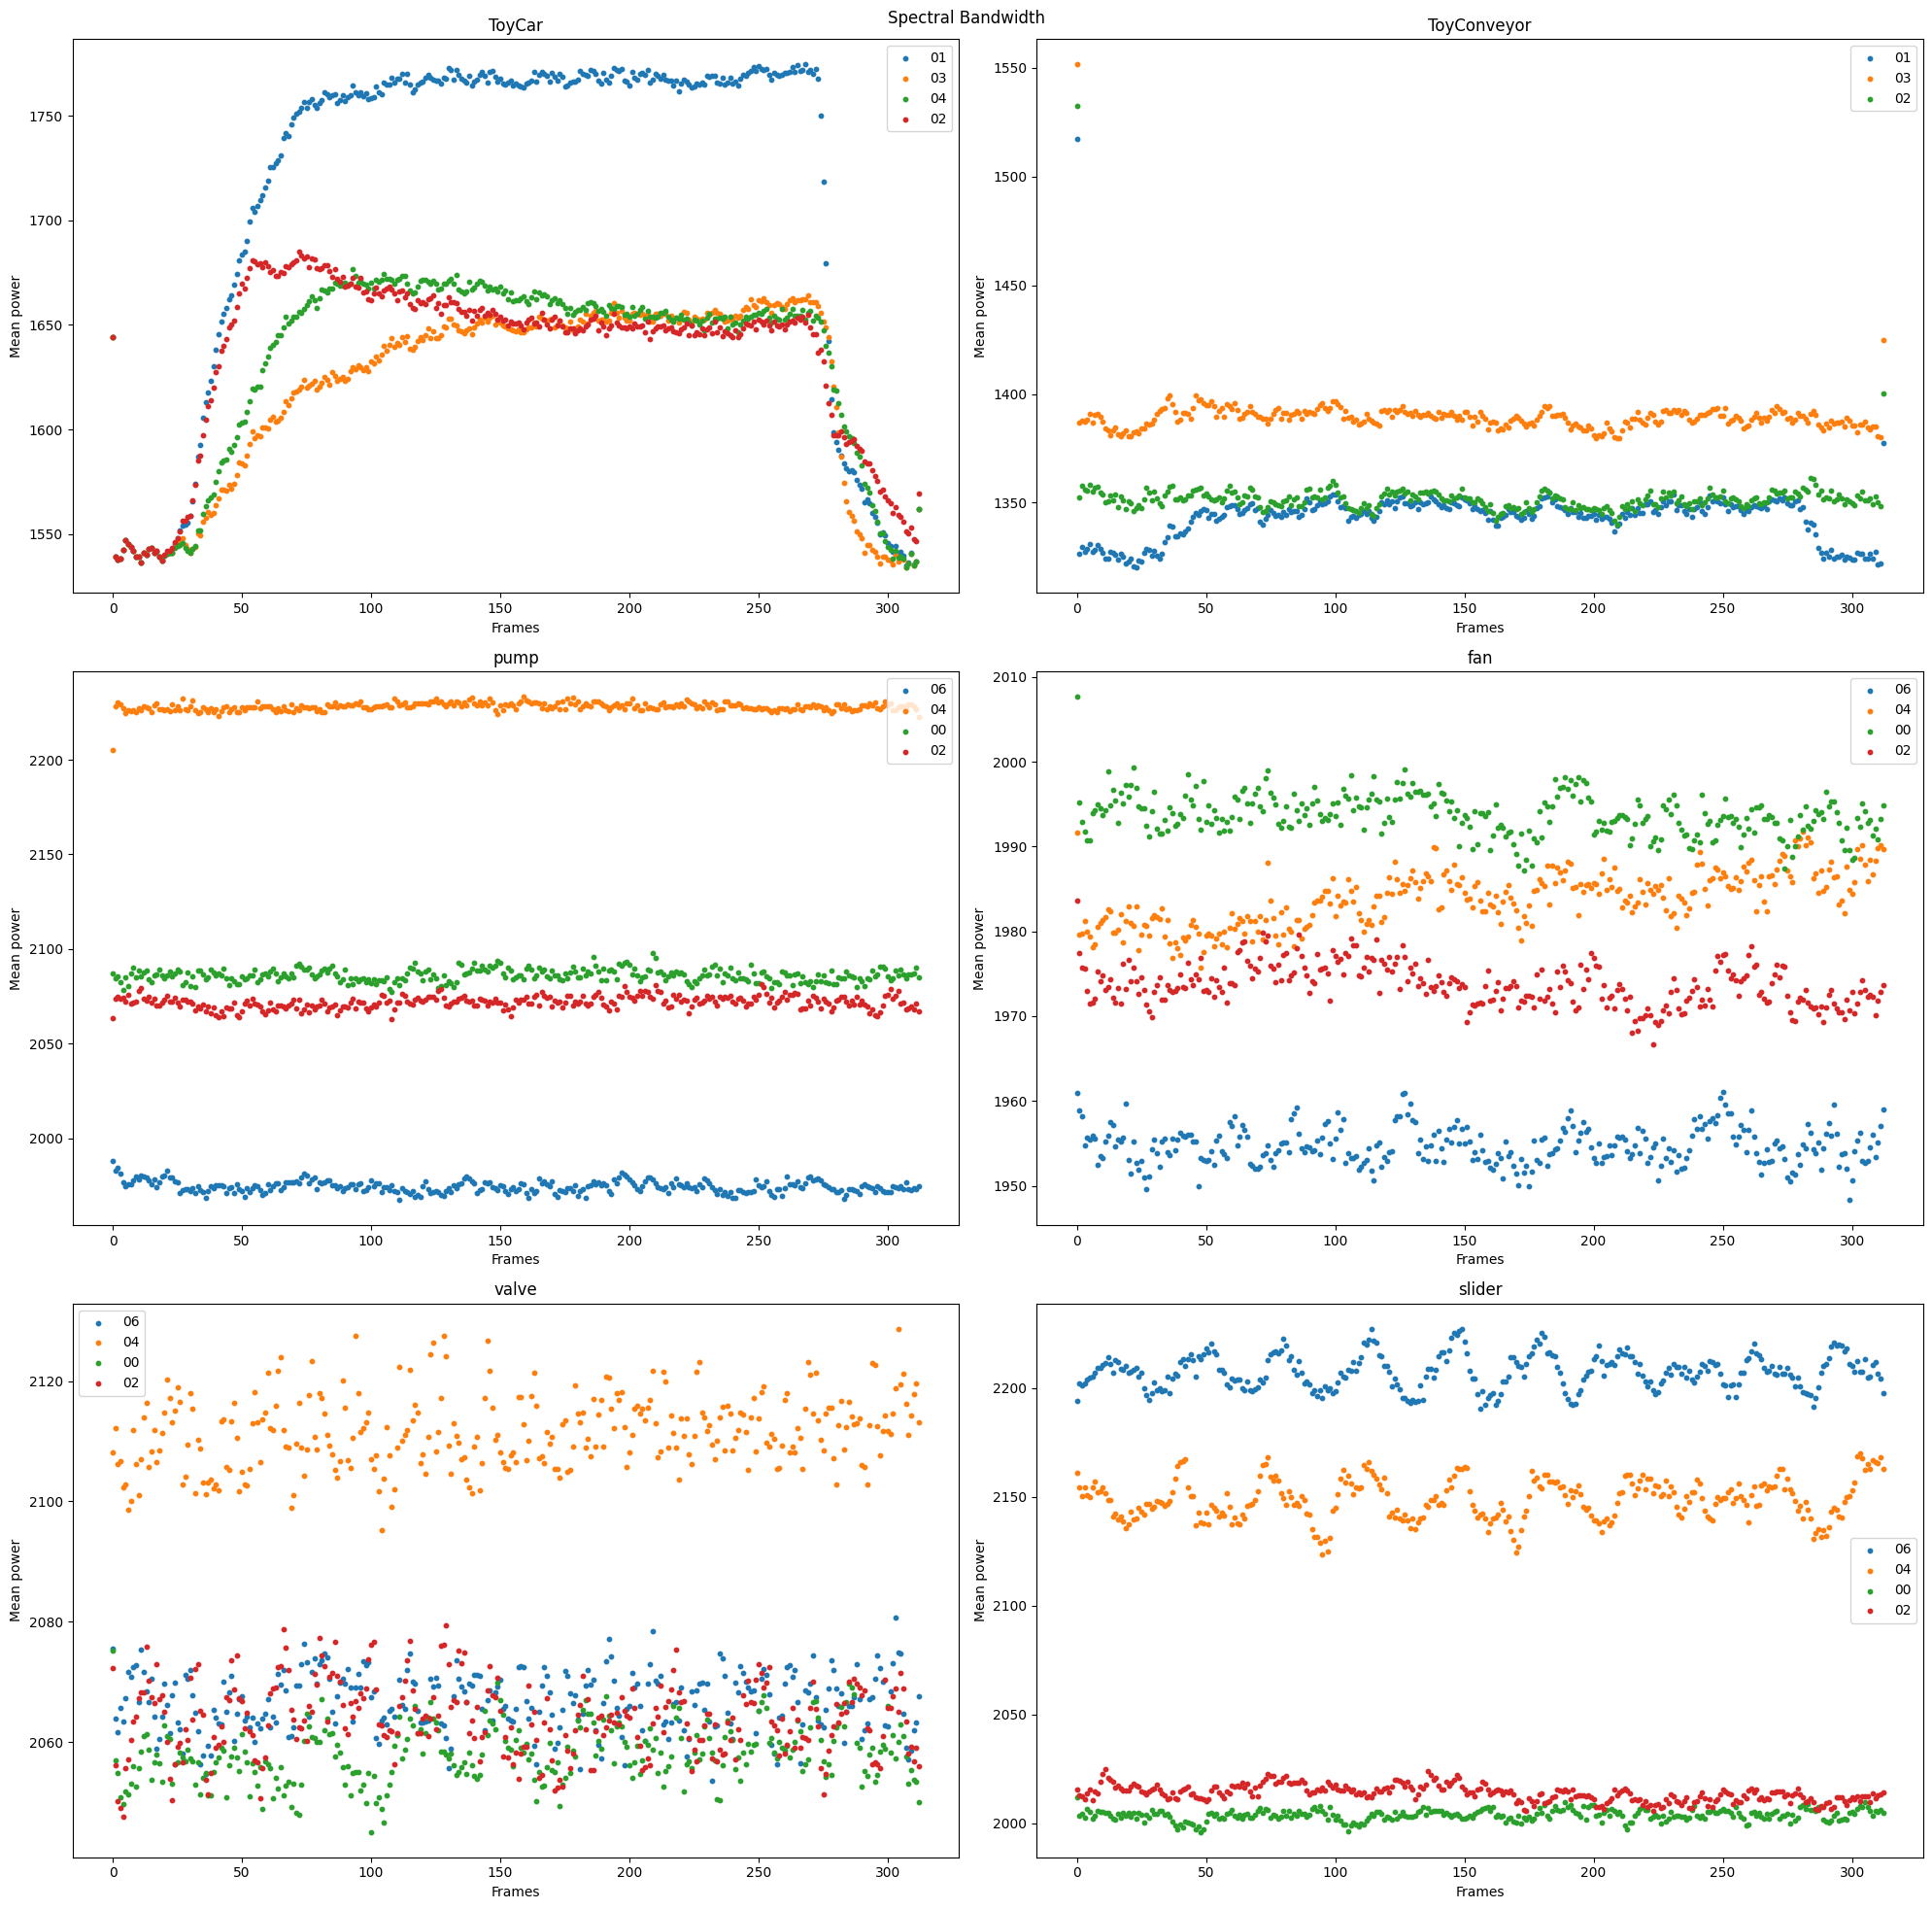

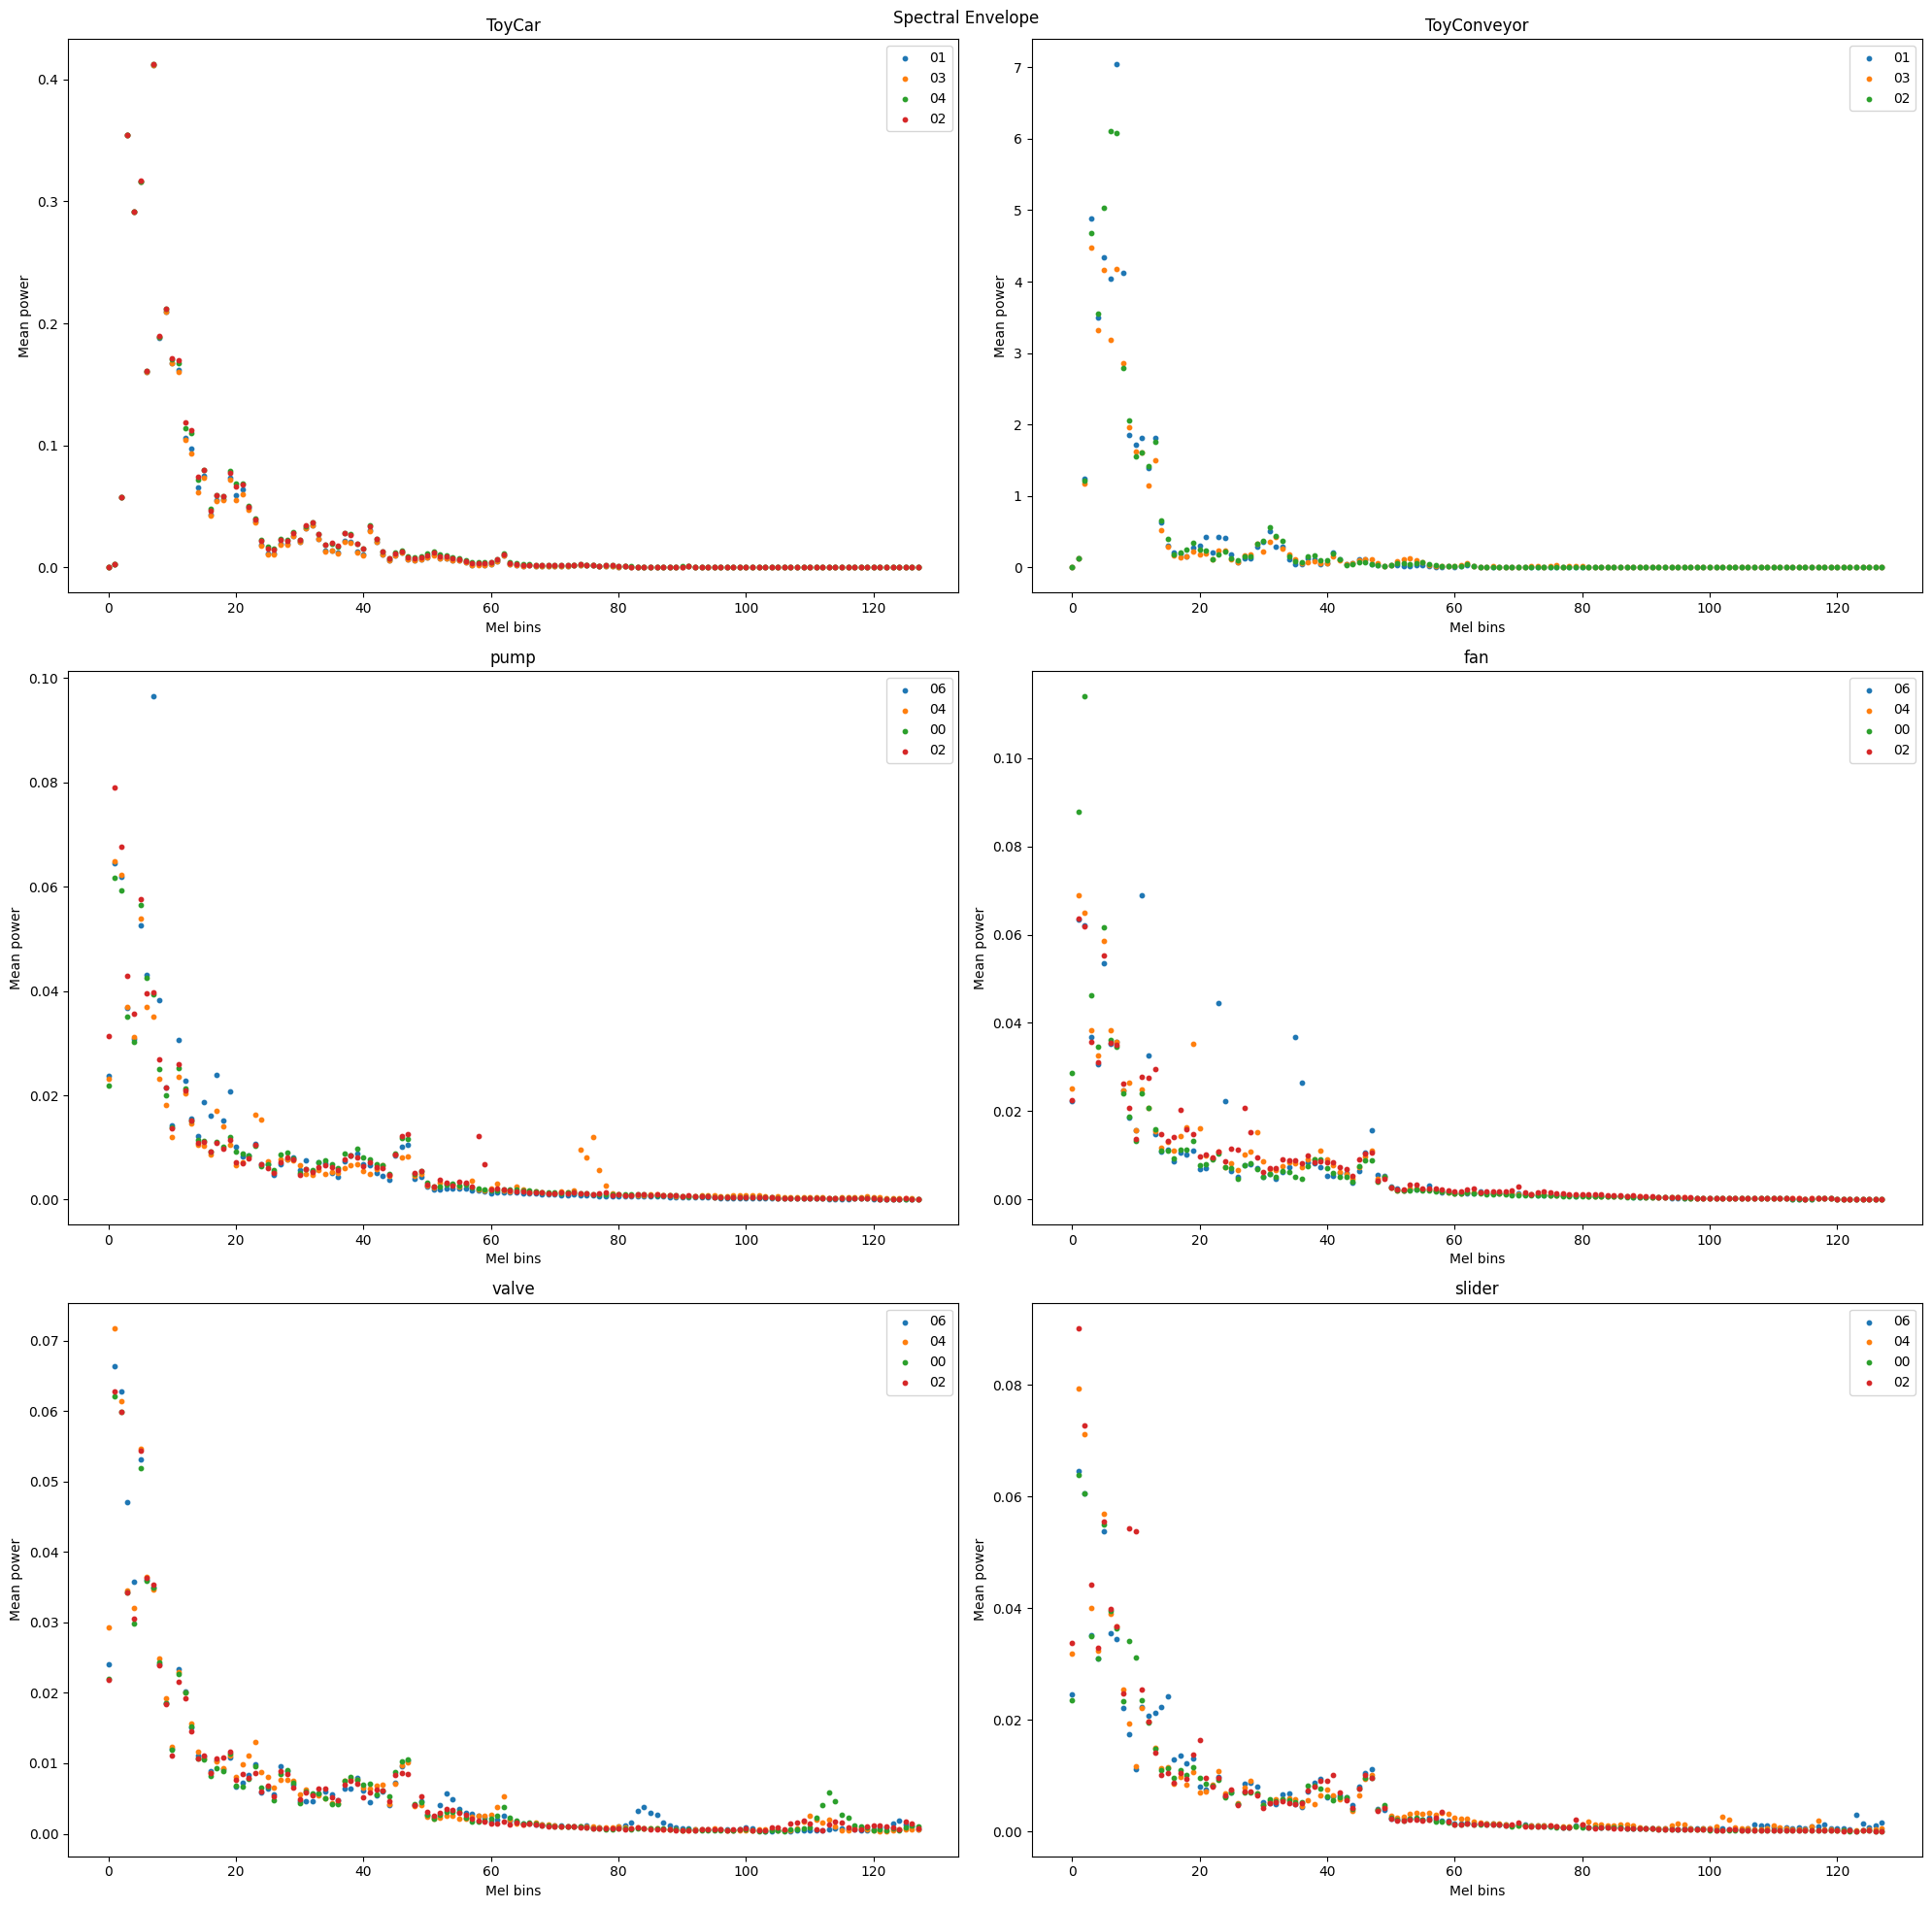

In [15]:
ncols = 2
nrows = int(np.ceil(len(machine_types) / ncols))

for metric, metric_agg_stats in agg_stats.items():
    xlabel = "Mel bins" if metric in metrics_dict["frequency"] else "Frames"
    ylabel = "Frequency" if metric in metrics_dict["time_frequency"] else "Power"
    fig, ax = plt.subplots(figsize=(20, 20), ncols=ncols, nrows=nrows)
    fig.suptitle(metric.replace("_", " ").title())
    for machine_type, machine_type_stats in metric_agg_stats.items():
        row = machine_types.index(machine_type) // ncols
        col = machine_types.index(machine_type) % ncols
        for machine_id, machine_id_stats in machine_type_stats.items():
            x = range(machine_id_stats.shape[0])
            ax[row, col].scatter(x=x, y=machine_id_stats, label=machine_id, s=10)
        ax[row, col].set_title(machine_type)
        ax[row, col].set_xlabel(xlabel)
        ax[row, col].set_ylabel("Mean power")
        ax[row, col].legend()
    plt.tight_layout()
    plt.show()

### Aggregated by Machine Type

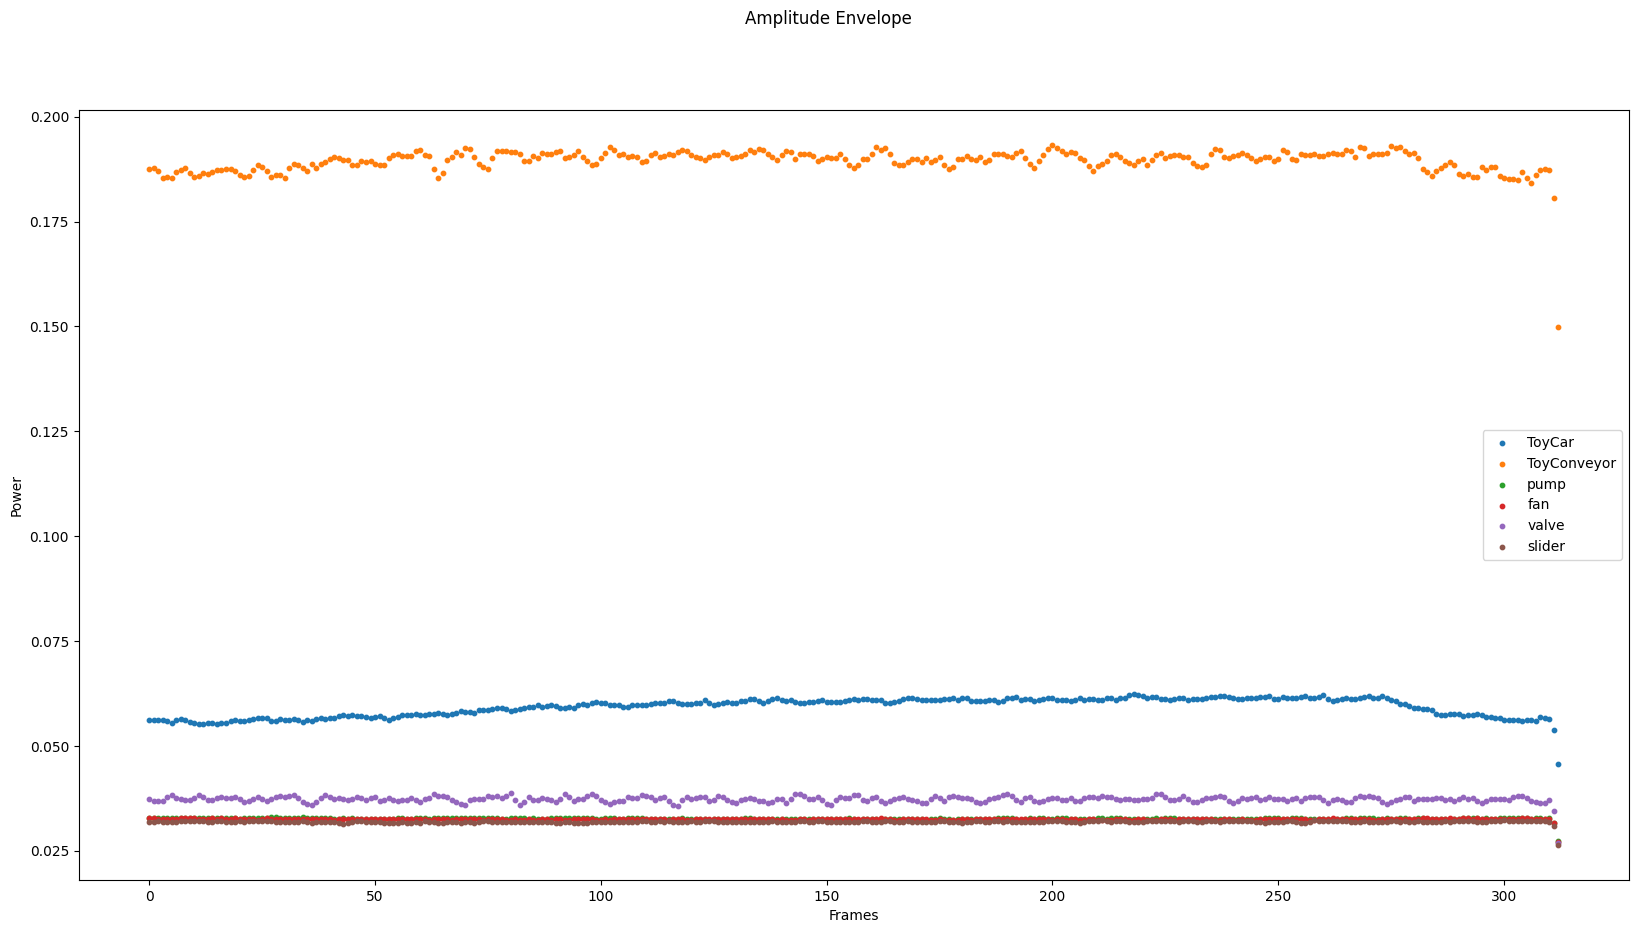

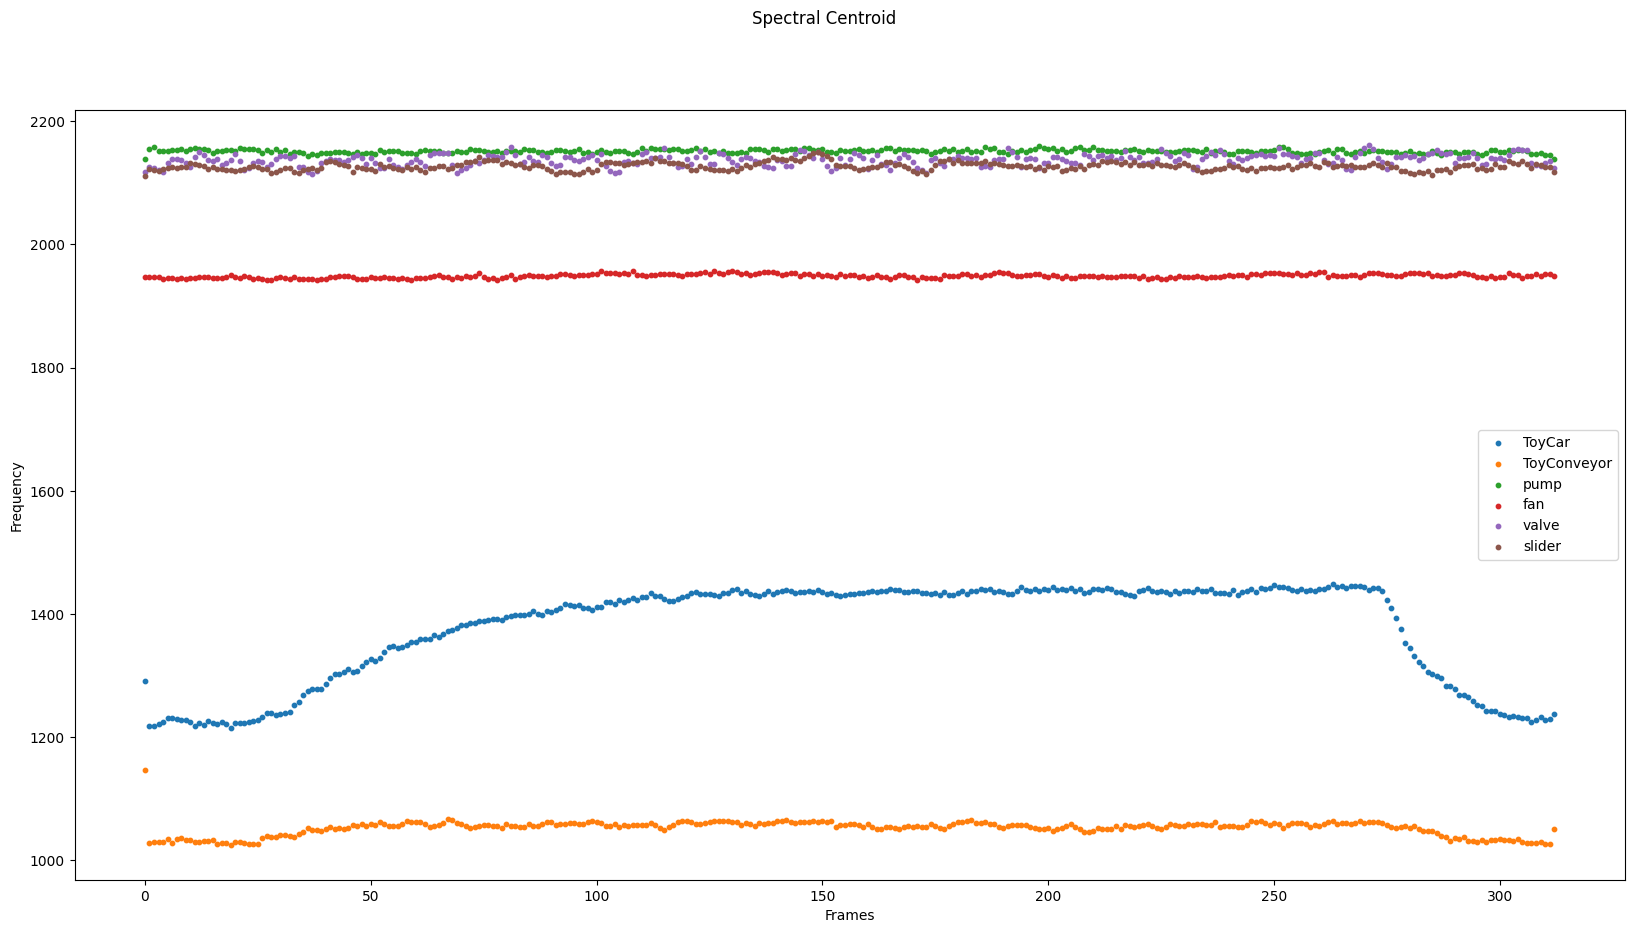

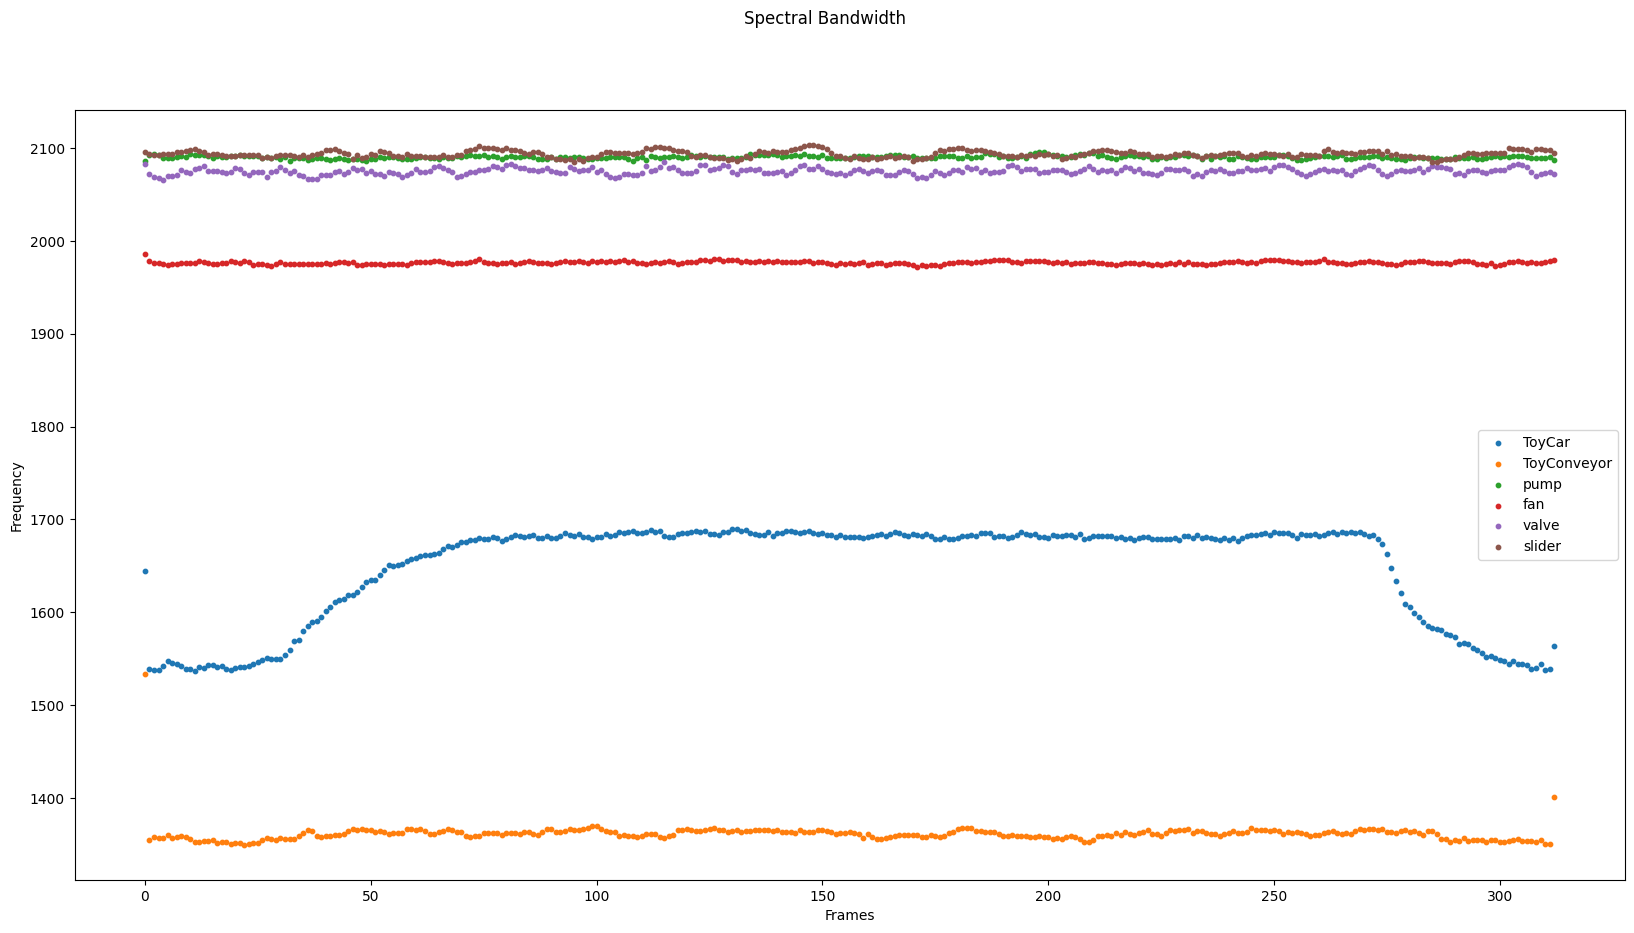

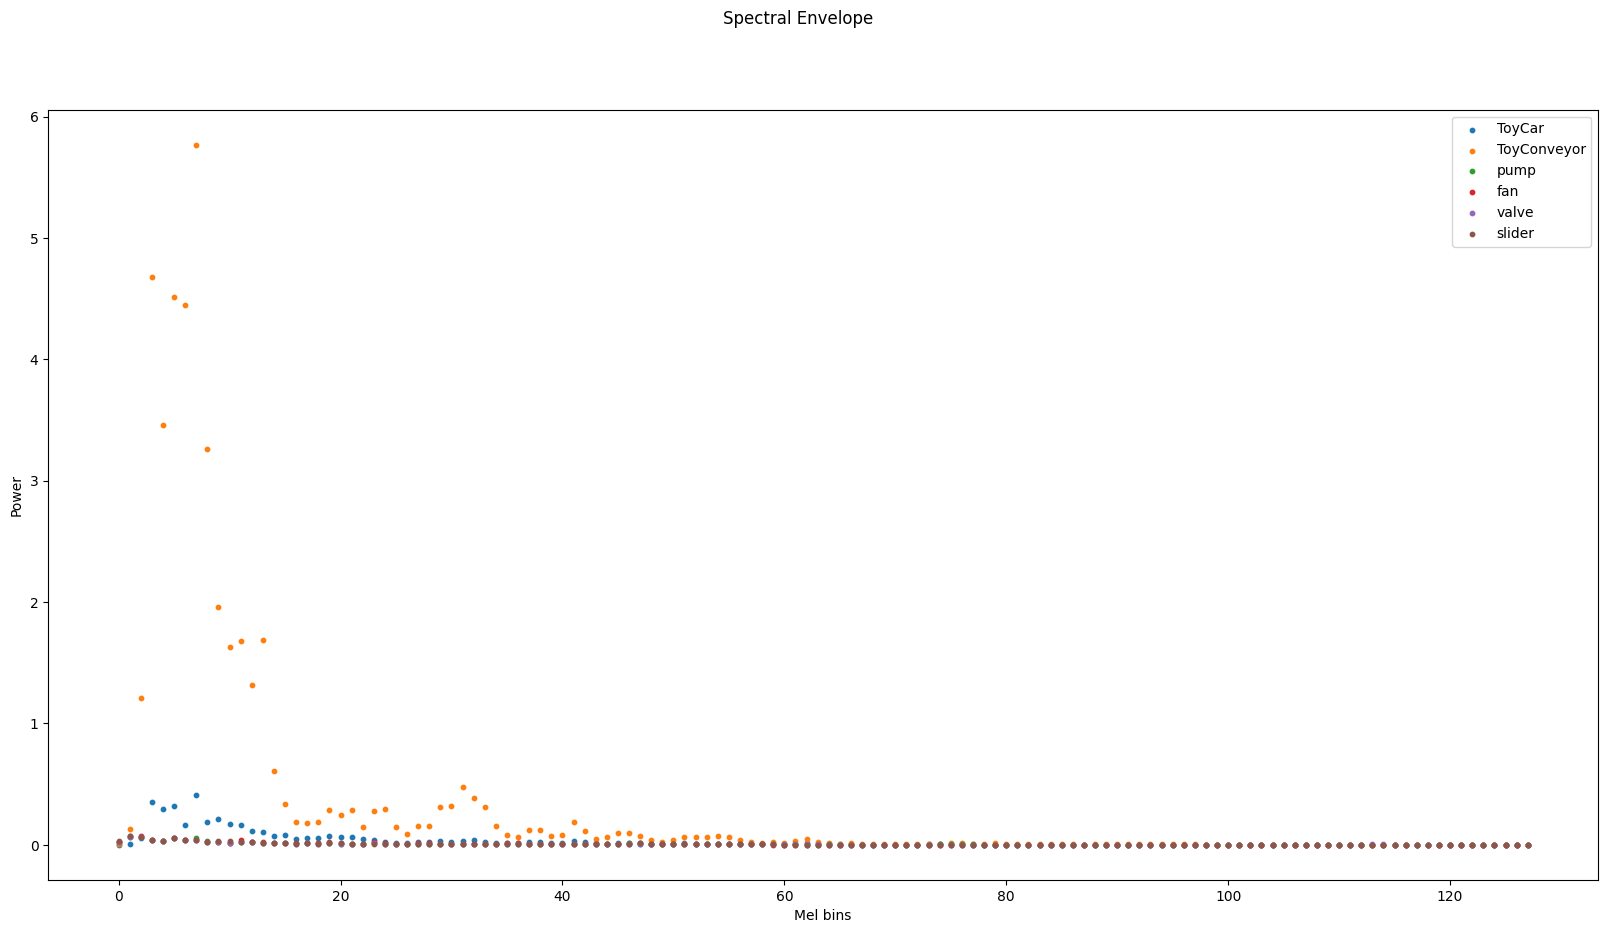

In [16]:
for metric, metric_agg_stats in agg_stats.items():
    xlabel = "Mel bins" if metric in metrics_dict["frequency"] else "Frames"
    ylabel = "Frequency" if metric in metrics_dict["time_frequency"] else "Power"
    fig, ax = plt.subplots(figsize=(20, 10))
    fig.suptitle(metric.replace("_", " ").title())
    for machine_type, stats in metric_agg_stats.items():
        mean_stats = np.array(list(stats.values())).mean(axis=0)
        plt.scatter(x=range(mean_stats.shape[0]), y=mean_stats, label=machine_type, s=10)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()